In [1]:
import time
from datetime import datetime
import pandas as pd
import numpy as np
import itertools
from datetime import timedelta  

# Just to use YahooDownloader
# import finrl

In [2]:
# query_string="https://query1.finance.yahoo.com/v7/finance/download/TSLA?period1=1606780800&period2=1609372800&interval=1wk&events=history&includeAdjustedClose=true"
#ticker = 'TSLA'
#period1 = int(time.mktime(datetime.datetime(2020,12,1, 23,59).timetuple()))
#period2 = int(time.mktime(datetime.datetime(2020,12,31, 23,59).timetuple()))
#interval='1wk' # 1d, 1m
#interval = '1d'
#query_string=f"https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true"
#df = pd.read_csv(query_string)

## 1. Get universe of stocks. 

We have downloaded a snapshot of DJI universe. We take list of tickers from `data/DJI_tickers.csv`

In [3]:
tickers_df = pd.read_csv("../data/DJI_tickers.csv")
tickers = tickers_df["DOW_30_TICKER"].values
print(tickers)

['AAPL' 'MSFT' 'JPM' 'V' 'RTX' 'PG' 'GS' 'NKE' 'DIS' 'AXP' 'HD' 'INTC'
 'WMT' 'IBM' 'MRK' 'UNH' 'KO' 'CAT' 'TRV' 'JNJ' 'CVX' 'MCD' 'VZ' 'CSCO'
 'XOM' 'BA' 'MMM' 'PFE' 'WBA' 'DD']


## 2. Download historical data

In [4]:
import time
from datetime import datetime

def ticker_downloader(p_start_date_str, p_end_date_str, p_ticker, p_interval = '1d'):
    # Add timestamp
    st = p_start_date_str + " " + "23:59"
    end = p_end_date_str + " " + "23:59"
    # Reconvert to timestamp
    st = datetime.strptime(st, "%Y.%m.%d %H:%M")
    end = datetime.strptime(end, "%Y.%m.%d %H:%M")
    # Get back system time format for final query
    period1 = int(time.mktime(st.timetuple()))
    period2 = int(time.mktime(end.timetuple()))
    query_string=f"https://query1.finance.yahoo.com/v7/finance/download/{p_ticker}?period1={period1}&period2={period2}&interval={p_interval}&events=history&includeAdjustedClose=true"
    result_df = None
    try:
        result_df = pd.read_csv(query_string)
    except Exception as e:
        print("Oops!", e.__class__, "occurred.")
        print(f"ticker_downloader: For ticker={p_ticker}, start={p_start_date_str}, end={p_end_date_str}: {e}")
        return None
    return result_df


# Test using TSLA
#ticker_downloader("2020.12.01", "2020.12.31", "TSLA")
# Test using non existent TSLA
# ticker_downloader("2020.12.01", "2020.12.31", "TSLAXXX")
# Test using non existent in date
# ticker_downloader("1980.12.01", "2020.12.31", "TSLA")


def download_all_tickers(p_start_date_str, p_end_date_str, p_tickers_list, sleep=True):
    # make sure in correct input format
    p_start_date_str = datetime.strptime(p_start_date_str,"%Y.%m.%d").strftime("%Y.%m.%d")
    p_end_date_str = datetime.strptime(p_end_date_str  ,"%Y.%m.%d").strftime("%Y.%m.%d")
    
    data_dict = {}
    for ticker in p_tickers_list:
        # Not sure if Yahoo blocks me for very fast request, lets sleep for random 0-5 seconds
        if sleep:
            if ticker != p_tickers_list[0]:
                time.sleep(np.random.randint(low = 0, high = 5, size = 1)[0])
        print(f"Downloading {ticker}..")
        data_dict[ticker] = ticker_downloader(p_start_date_str, p_end_date_str, ticker, '1d')
        # add ticker information if it is found
        if data_dict[ticker] is not None:
            data_dict[ticker]["tic"] = ticker
    print("Download finished! Organising records now..")
    # join whole universe with this data
    all_data = pd.concat([v for k,v in data_dict.items()])
    del data_dict
    # Some data may be missing - let us create a union of them all
    all_data["Date"] = [ datetime.strptime(dt,"%Y-%m-%d").date() for dt in all_data.Date.values]
    all_data = pd.DataFrame(list(itertools.product(all_data["Date"].unique(),all_data["tic"].unique())))\
                    .rename(columns={0:"Date", 1:"tic"})\
                    .merge(all_data, how='left',  left_on=["Date", "tic"], right_on=["Date", "tic"])\
                    .sort_values(by=["Date", "tic"])
    print("Done!")
    return all_data
        


In [5]:
all_data = download_all_tickers("1990.01.01", "2021.12.01", tickers)

Download finished! Organising records now..
Done!


In [6]:
all_data

,Date,tic,Open,High,Low,Close,Adj Close,Volume
0,1990-01-02,AAPL,0.314732,0.334821,0.312500,0.332589,0.266423,183198400.0
9,1990-01-02,AXP,8.915386,9.011943,8.851015,8.979757,5.152585,4301237.0
25,1990-01-02,BA,19.791668,20.500000,19.666668,20.500000,11.043624,2042400.0
17,1990-01-02,CAT,7.234375,7.359375,7.218750,7.359375,3.404977,2910400.0
23,1990-01-02,CSCO,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
241263,2021-12-01,V,196.029999,196.809998,190.100006,190.160004,190.160004,13204900.0
241282,2021-12-01,VZ,50.500000,50.919998,49.740002,49.770000,49.770000,26295500.0
241288,2021-12-01,WBA,45.299999,45.700001,43.689999,43.720001,43.720001,6257600.0
241272,2021-12-01,WMT,140.509995,140.720001,137.039993,137.139999,137.139999,12207100.0


In [7]:
# Adjusts all intraday prices by adj factor derived from "Adj Close" and Close
def adjust_prices(p_data_df):
    ## Some preprocessing here  Adj Close = Close * adj_factor
    ## Similarly we can adjust all related prices Open	High	Low	Close
    adj_factor = p_data_df["Adj Close"]/p_data_df["Close"]
    all_data_adj = p_data_df.copy()
    for colname in ["Open","High","Low","Close"]:
        all_data_adj[colname]  = all_data_adj[colname] * adj_factor
        all_data_adj = all_data_adj.rename(columns = {colname: colname.lower()})
    all_data_adj.drop(columns = ["Adj Close"], inplace = True)
    all_data_adj = all_data_adj.rename(columns = {"Volume": "volume"})
    return all_data_adj

# Example here
all_data_adj = adjust_prices(p_data_df = all_data)
all_data_adj

,Date,tic,open,high,low,close,volume
0,1990-01-02,AAPL,0.252119,0.268211,0.250331,0.266423,183198400.0
9,1990-01-02,AXP,5.115649,5.171053,5.078713,5.152585,4301237.0
25,1990-01-02,BA,10.662036,11.043624,10.594697,11.043624,2042400.0
17,1990-01-02,CAT,3.347143,3.404977,3.339914,3.404977,2910400.0
23,1990-01-02,CSCO,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
241263,2021-12-01,V,196.029999,196.809998,190.100006,190.160004,13204900.0
241282,2021-12-01,VZ,50.500000,50.919998,49.740002,49.770000,26295500.0
241288,2021-12-01,WBA,45.299999,45.700001,43.689999,43.720001,6257600.0
241272,2021-12-01,WMT,140.509995,140.720001,137.039993,137.139999,12207100.0


In [8]:
# All stats of difference must be close to 0 here ( except count)
(all_data["Adj Close"] - all_data_adj["close"]).describe()

count    2.343070e+05
mean     6.456266e-19
std      1.104466e-15
min     -2.842171e-14
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.842171e-14
dtype: float64

In [9]:
all_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,234307.000000,234307.000000,234307.000000,234307.000000,234307.000000,2.343070e+05
mean,54.208597,54.749205,53.660786,54.215964,43.041269,2.620766e+07
std,52.523642,53.000542,52.037905,52.524406,50.463134,9.741427e+07
min,0.000000,0.072917,0.068576,0.071181,0.052134,1.880000e+04
25%,21.170000,21.409828,20.932446,21.170000,12.402326,3.815250e+06
50%,39.400002,39.860001,38.922501,39.400002,25.741207,6.942500e+06
75%,70.122143,70.914410,69.449997,70.161110,54.156765,1.436495e+07
max,465.390015,466.000000,460.290009,464.350006,462.840424,7.421641e+09


In [10]:
all_data_adj.describe()

,open,high,low,close,volume
count,234307.000000,234307.000000,234307.000000,234307.000000,2.343070e+05
mean,43.036520,43.459568,42.607260,43.041269,2.620766e+07
std,50.464046,50.930222,49.987517,50.463134,9.741427e+07
min,0.000000,0.053405,0.050226,0.052134,1.880000e+04
25%,12.400895,12.551906,12.251935,12.402326,3.815250e+06
50%,25.731476,26.048316,25.426253,25.741207,6.942500e+06
75%,54.131403,54.648997,53.649273,54.156765,1.436495e+07
max,463.877050,464.485052,458.793626,462.840424,7.421641e+09


In [11]:
row_contains_nan = all_data.isnull().any(axis=1)
all_data.loc[row_contains_nan,]

,Date,tic,Open,High,Low,Close,Adj Close,Volume
23,1990-01-02,CSCO,NaN,NaN,NaN,NaN,NaN,NaN
6,1990-01-02,GS,NaN,NaN,NaN,NaN,NaN,NaN
3,1990-01-02,V,NaN,NaN,NaN,NaN,NaN,NaN
53,1990-01-03,CSCO,NaN,NaN,NaN,NaN,NaN,NaN
36,1990-01-03,GS,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
137583,2008-03-12,V,NaN,NaN,NaN,NaN,NaN,NaN
137613,2008-03-13,V,NaN,NaN,NaN,NaN,NaN,NaN
137643,2008-03-14,V,NaN,NaN,NaN,NaN,NaN,NaN
137673,2008-03-17,V,NaN,NaN,NaN,NaN,NaN,NaN


We can see that in  our selectes rics, we see that after 2008-03-18, we do not have any empty rows, i.e. all the stocks of data. So we focus on this universe only after this date.

### Add returns to the data

In [12]:
def add_returns(p_data_df, p_price_column_name):
    returns = p_data_df.groupby(["tic"])\
                .apply( lambda df: df.set_index("Date")[[p_price_column_name]]\
                                     .pct_change()\
                                     .reset_index())\
                .reset_index()\
                .drop(columns=["level_1"])\
                .sort_values(by=["Date", "tic"])\
                .rename(columns = {p_price_column_name : "returns" + "_"+ p_price_column_name })

    res = p_data_df.merge(returns, how='left',  left_on=["Date", "tic"], right_on=["Date", "tic"])
    return res

# Example
add_returns(all_data_adj, "close")
add_returns(all_data, "Adj Close")

,Date,tic,Open,High,Low,Close,Adj Close,Volume,returns_Adj Close
0,1990-01-02,AAPL,0.314732,0.334821,0.312500,0.332589,0.266423,183198400.0,NaN
1,1990-01-02,AXP,8.915386,9.011943,8.851015,8.979757,5.152585,4301237.0,NaN
2,1990-01-02,BA,19.791668,20.500000,19.666668,20.500000,11.043624,2042400.0,NaN
3,1990-01-02,CAT,7.234375,7.359375,7.218750,7.359375,3.404977,2910400.0,NaN
4,1990-01-02,CSCO,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
241285,2021-12-01,V,196.029999,196.809998,190.100006,190.160004,190.160004,13204900.0,-0.018630
241286,2021-12-01,VZ,50.500000,50.919998,49.740002,49.770000,49.770000,26295500.0,-0.009946
241287,2021-12-01,WBA,45.299999,45.700001,43.689999,43.720001,43.720001,6257600.0,-0.024107
241288,2021-12-01,WMT,140.509995,140.720001,137.039993,137.139999,137.139999,12207100.0,-0.024817


In [13]:
download_all_tickers("1990.01.01", "2021.12.01", ["SPX"], sleep=True)

Download finished! Organising records now..
Done!


,Date,tic,Open,High,Low,Close,Adj Close,Volume
0,2000-03-02,SPX,1.74884,2.49834,1.74884,2.49834,2.49834,2562.0
1,2000-03-03,SPX,1.87375,1.87375,1.87375,1.87375,1.87375,80.0
2,2000-03-06,SPX,2.49834,2.49834,2.49834,2.49834,2.49834,240.0
3,2000-03-07,SPX,4.37209,4.37209,4.37209,4.37209,4.37209,0.0
4,2000-03-08,SPX,4.37209,4.37209,4.37209,4.37209,4.37209,0.0
...,...,...,...,...,...,...,...,...
5469,2021-11-24,SPX,NaN,NaN,NaN,NaN,NaN,NaN
5470,2021-11-26,SPX,NaN,NaN,NaN,NaN,NaN,NaN
5471,2021-11-29,SPX,NaN,NaN,NaN,NaN,NaN,NaN
5472,2021-11-30,SPX,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
#download_all_tickers("1990.01.01", "2021.12.01", ["HYS"], sleep=True)
#download_all_tickers("1990.01.01", "2021.12.01", ["HYG"], sleep=True) 
#download_all_tickers("1990.01.01", "2021.12.01", ["USHY"], sleep=True) 
#download_all_tickers("1990.01.01", "2021.12.01", ["JPHY"], sleep=True) 
#download_all_tickers("1990.01.01", "2021.12.01", ["USIG"], sleep=True) 
# download_all_tickers("1990.01.01", "2021.12.01", ["EMB"], sleep=True) 
# download_all_tickers("1990.01.01", "2021.12.01", ["EMHY"], sleep=True)
# download_all_tickers("1990.01.01", "2021.12.01", ["^VIX"], sleep=True)
download_all_tickers("1990.01.01", "2021.12.01", ["IEF"], sleep=True)

Download finished! Organising records now..
Done!


,Date,tic,Open,High,Low,Close,Adj Close,Volume
0,2002-07-30,IEF,81.940002,82.120003,81.699997,81.769997,46.569592,41300
1,2002-07-31,IEF,82.050003,82.580002,82.050003,82.519997,46.996742,32600
2,2002-08-01,IEF,82.540001,82.900002,82.519997,82.860001,47.190361,71400
3,2002-08-02,IEF,83.019997,83.699997,82.900002,83.500000,47.554817,120300
4,2002-08-05,IEF,83.680000,83.919998,83.529999,83.919998,47.794064,159300
...,...,...,...,...,...,...,...,...
4866,2021-11-24,IEF,113.570000,113.919998,113.500000,113.900002,113.813438,8322900
4867,2021-11-26,IEF,114.980003,115.389999,114.919998,115.370003,115.282326,13878500
4868,2021-11-29,IEF,114.690002,115.199997,114.660004,115.110001,115.022522,13908200
4869,2021-11-30,IEF,115.820000,116.150002,115.220001,115.800003,115.711998,19416800


## Other Indexes/asset classes we can look for are:

This website has ETF information for a variety of asset classes: https://etfdb.com/etfdb-categories/

We check data availability for each of them using `download_all_tickers`. 
The (YYYY-MM-DD + ) represents date from which data is available

* Bond/Fixed Income
    *  (Corporate Bonds ETF)iShares Broad USD Investment Grade Corporate Bond ETF => USIG (2007-01-11 + )
    
    *  (Corporate Bonds ETF) iShares iBoxx $ Investment Grade Corporate Bond ETF => LQD (2002-07-30 +)
    
    *  (High Yield Bonds ETF) iShares iBoxx $ High Yield Corporate Bond ETF => HYG (2007-04-11+)
    
    *  (Emerging Markets Bonds) iShares J.P. Morgan USD Emerging Markets Bond ETF -> EMB( 2007-12-19 + )
    
    *  (Emerging Markets Bonds) iShares J.P. Morgan EM High Yield Bond ETF -> EMHY (2012-04-03)
    
    *  (Government Bonds ETF) iShares U.S. Treasury Bond ETF -> GOVT (2012-02-24 + )
    
    *  (Government Bonds ETF) iShares 1-3 Year Treasury Bond ETF->SHY(2002-07-30 +)
    
    *  (Government Bonds ETF) iShares 20+ Year Treasury Bond ETF -> TLT 
    
    * (Government Bonds ETF) 	iShares 7-10 Year Treasury Bond ETF -> IEF (2002-07-30	+)
    
    *  (Money Market ETF) JPMorgan Ultra-Short Income ETF -> JPST(2017-06-23 +)
    
    *  (Total Bond Market ETF) iShares Core U.S. Aggregate Bond ETF -> AGG (2003-09-29	+)
    
    
* Equities:
    * (All Cap Equities ETF) SPDR Portfolio S&P 1500 Composite Stock Market ETF =>SPTM=> (2000-10-10+)


* Real Estate:
    * iShares Global REIT ETF => REET (2014+)
    * SPDR Dow Jones Global Real Estate ETF=> RWO (2008-05-22+)
    * SPDR Dow Jones International Real Estate ETF => RWX (2006-12-19+)
    
* Volatility ETF
    * (Volatility ETF) iPath Series B S&P 500 VIX Short-Term Futures  => ETN (1990-01-02 +):
    
    The Index is designed to provide access to equity market volatility through CBOE Volatility Index. This can be used to not only instrument to invest but also is a market view in future returns of volatility.
    https://www.ipathetn.com/US/16/en/details.app?instrumentId=341408
   
* CBOE Volatility Index => ^VIX (1990-01-02+)
    * The VIX Index is a calculation designed to produce a measure of constant, 30-day expected volatility of the U.S. stock market, derived from real-time. This could be a guaage of future volatility. A good option to be state variable for DQN.
    
  
* Precious Metals ETF 
    * SPDR Gold Shares => GLD (2004-11-18+)
    Gold offers investors an attractive opportunity to diversify their portfolios. During recessions or heavy volatily it becomes a safer investement. https://www.spdrgoldshares.com/

* S&P Index 
    * https://corporatefinanceinstitute.com/resources/knowledge/trading-investing/sp-500-index-ticker-symbol/
    * Price index of stocks (untradeable) :^GSPC  (1990-01-02+)
    * SPDR S&P 500 ETF (tradeable)==> SPY (1993-01-29+) 


In [15]:
#download_all_tickers("1990.01.01", "2021.12.01", ["ETN"], sleep=True)
#download_all_tickers("1990.01.01", "2021.12.01", ["VXX"], sleep=True)
download_all_tickers("1990.01.01", "2021.12.01", ["^GSPC"], sleep=True) 

Download finished! Organising records now..
Done!


,Date,tic,Open,High,Low,Close,Adj Close,Volume
0,1990-01-02,^GSPC,353.399994,359.690002,351.980011,359.690002,359.690002,162070000
1,1990-01-03,^GSPC,359.690002,360.589996,357.890015,358.760010,358.760010,192330000
2,1990-01-04,^GSPC,358.760010,358.760010,352.890015,355.670013,355.670013,177000000
3,1990-01-05,^GSPC,355.670013,355.670013,351.350006,352.200012,352.200012,158530000
4,1990-01-08,^GSPC,352.200012,354.239990,350.540009,353.790009,353.790009,140110000
...,...,...,...,...,...,...,...,...
8038,2021-11-24,^GSPC,4675.779785,4702.870117,4659.890137,4701.459961,4701.459961,2464040000
8039,2021-11-26,^GSPC,4664.629883,4664.629883,4585.430176,4594.620117,4594.620117,2676740000
8040,2021-11-29,^GSPC,4628.750000,4672.950195,4625.259766,4655.270020,4655.270020,3471380000
8041,2021-11-30,^GSPC,4640.250000,4646.020020,4560.000000,4567.000000,4567.000000,4950190000


In [16]:
download_all_tickers("1990.01.01", "2021.12.01", ["SPY"], sleep=True) 

Download finished! Organising records now..
Done!


,Date,tic,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,SPY,43.968750,43.968750,43.750000,43.937500,25.717390,1003200
1,1993-02-01,SPY,43.968750,44.250000,43.968750,44.250000,25.900293,480500
2,1993-02-02,SPY,44.218750,44.375000,44.125000,44.343750,25.955154,201300
3,1993-02-03,SPY,44.406250,44.843750,44.375000,44.812500,26.229548,529400
4,1993-02-04,SPY,44.968750,45.093750,44.468750,45.000000,26.339283,531500
...,...,...,...,...,...,...,...,...
7259,2021-11-24,SPY,466.059998,469.570007,465.190002,469.440002,469.440002,61858800
7260,2021-11-26,SPY,462.339996,463.899994,457.769989,458.970001,458.970001,112669600
7261,2021-11-29,SPY,464.070007,466.559998,461.730011,464.600006,464.600006,86268800
7262,2021-11-30,SPY,462.000000,464.029999,455.299988,455.559998,455.559998,148559600


#### Instruments of interest.
Note that `date` is what I think date of avilability starts from. However, we will try finding out.

In [17]:
instruments_of_interest_df = pd.DataFrame(
                              [ {"tic": "USIG",
                                           "date" : "2007-01-11",
                                           "type" : "Corporate Bonds ETF",
                                           "name" :"iShares Broad USD Investment Grade Corporate Bond ETF"     
                                           },
                                 {"tic": "LQD",
                                           "date" : "2002-07-30",
                                           "type" : "Corporate Bonds ETF",
                                           "name" : "iShares iBoxx $ Investment Grade Corporate Bond ETF"     
                                        },
                                 { "tic": "HYG",
                                        "date" : "2007-04-11",
                                           "type" : "High Yield Bonds ETF",
                                           "name" : "iShares iBoxx $ High Yield Corporate Bond ETF"    
                                       },
                                
                                
                                
                                { "tic": "SHY",
                                        "date" : "2002-07-30",
                                           "type" : "Government Bonds ETF",
                                           "name" : "iShares 1-3 Year Treasury Bond ETF"    
                                       },
                                
                                
                                {  "tic": "TLT",
                                        "date"  : "2002-07-30",
                                           "type" : "Government Bonds ETF",
                                           "name" : "iShares 20+ Year Treasury Bond ETF"    
                                       },
                                
                                
                                { "tic": "SPTL",
                                         "date" : "2007-05-30",
                                           "type" : "Government Bonds ETF",
                                           "name" : "SPDR Portfolio Long Term Treasury ETF"    
                                       },  
                                
                                {  "tic":"IEF",
                                        "date" : "2007-05-30",
                                           "type" : "Government Bonds ETF",
                                           "name" : "iShares 7-10 Year Treasury Bond ETF"    
                                       },                                
                                
                                { "tic": "AGG",
                                        "date" : "2003-09-29",
                                           "type" : "Total Bond Market ETF",
                                           "name" : "iShares Core U.S. Aggregate Bond ETF"    
                                       },
                                
                                # https://etfdb.com/etf/SPTM/#etf-ticker-profile
                                # SPTM leans more heavily on large-cap stocks than the other three
                                # Large-Cap
                                { "tic": "SPTM",
                                         "date" : "2000-10-10",    
                                           "type" : "All Cap Equities ETF",
                                           "name" : "SPDR Portfolio S&P 1500 Composite Stock Market ETF" 
                                        },
                                
                                #mid cap stocks that exhibit growth characteristics
                                { "tic": "IWP",
                                        "date" : "2001-08-02",
                                           "type" : "All Cap Equities ETF",
                                           "name" : "iShares Russell Mid-Cap Growth ETF" 
                                        },
                                
                                {  "tic": "^GSPC",
                                         "date" : "1990-01-02",
                                           "type" : "Equities/Market",
                                           "name" : "S&P Index(untradeable)" 
                                        },
                                
                                { "tic":  "SPY",
                                        "date" : "1993-01-29",
                                           "type" : "Equities/Market",
                                           "name" : "SPDR S&P 500 ETF(tradeable)" 
                                        },
                                
                                ####---------- Equities - Themes --------------- ####
                                #Exposure to large- and mid-cap U.S. stocks exhibiting relatively higher price momentum
                                #Index-based access to a specific factor which has historically driven a significant part of companies' risk and return
                                # The iShares MSCI USA Momentum Factor ETF seeks to track the investment results of an index composed of U.S. large- and mid-capitalization stocks exhibiting relatively higher price momentum
                                # https://www.ishares.com/us/products/251614/
                                { "tic": "MTUM",
                                        "date" : "2009-09-14",
                                           "type" : "Equities/Market",
                                           "name" : "iShares MSCI USA Momentum Factor ETF" 
                                        },
                                
                                # Value
                                # https://www.ishares.com/us/products/239728/ishares-sp-500-value-etf
                                # The iShares S&P 500 Value ETF seeks to track the investment results 
                                # of an index composed of large-capitalization U.S. equities that exhibit 
                                # value characteristics.
                                { "tic": "IVE",
                                       "date" : "2000-05-26",
                                           "type" : "Equities/Market",
                                           "name" : "iShares S&P 500 Value ETF" 
                                        },
                                
                                # Growth
                                # https://www.ishares.com/us/products/239725/ishares-sp-500-growth-etf
                                {  "tic": "IVW",
                                       "date" : "2000-05-26",
                                           "type" : "Equities/Market",
                                           "name" : "iShares S&P 500 Growth ETF" 
                                    },
                                
                                # Quality
                                # https://www.ishares.com/us/products/256101/ishares-msci-usa-quality-factor-etf
                                # Exposure to large- and mid-cap U.S. stocks exhibiting positive fundamentals (high 
                                # return on equity, stable year-over-year earnings growth and low financial leverage)
                                {  "tic": "QUAL",
                                        "date" : "2013-07-18",
                                           "type" : "Equities/Market",
                                           "name" : "iShares MSCI USA Quality Factor ETF" 
                                    },
                                
                                ####---------- Equities - Market Cap Based --------------- ####
                                # Large cap
                                # https://www.ishares.com/us/products/239726/ishares-core-sp-500-etf
                                #1. Exposure to large, established U.S. companies
                                # The iShares Core S&P 500 ETF seeks to track the investment results 
                                #of an index composed of large-capitalization U.S. equities.
                                {  "tic": "IVV",
                                       "date" : "2000-05-26",
                                           "type" : "Equities/Market",
                                           "name" : "iShares Core S&P 500 ETF-LargeCap" 
                                        },
                                # Mid Cap
                                # https://www.ishares.com/us/products/239763/ishares-core-sp-midcap-etf
                                # The iShares Core S&P Mid-Cap ETF seeks to track the investment results 
                                # of an index composed of mid-capitalization U.S. equities.
                                {  "tic": "IJH",
                                       "date" : "2000-05-26",
                                           "type" : "Equities/Market",
                                           "name" : "iShares Core S&P Mid-Cap ETF" 
                                        },
                                
                                # Small-Cap
                                # The iShares Core S&P Small-Cap ETF seeks to track the investment 
                                # results of an index composed of small-capitalization U.S. equities.
                                # Exposure to U.S. small cap stocks
                                {  "tic": "IJR",
                                       "date" : "2000-05-26",
                                           "type" : "Equities/Market",
                                           "name" : "iShares Core S&P Small-Cap ETF" 
                                        },
                                
                                {  "tic": "ETN",
                                       "date": "1990-01-02",
                                           "type" : "Volatility ETF",
                                           "name" : "iPath Series B S&P 500 VIX Short-Term Futures" 
                                        },
                                
                                { "tic": "^VIX",
                                        "date": "1990-01-02",
                                           "type" : "Volatility Index",
                                           "name" : "CBOE Volatility Index " 
                                        },
                                
                                 { "tic":  "GLD",
                                        "date": "2004-11-18",
                                           "type" : "Precious Metals ETF",
                                           "name" : "SPDR Gold Shares" 
                                        }
                               ])
#del instruments_of_interest_dict   
#del instruments_of_interest
print("Instruments of interest:")
instruments_of_interest_df

Instruments of interest:


,tic,date,type,name
0,USIG,2007-01-11,Corporate Bonds ETF,iShares Broad USD Investment Grade Corporate B...
1,LQD,2002-07-30,Corporate Bonds ETF,iShares iBoxx $ Investment Grade Corporate Bon...
2,HYG,2007-04-11,High Yield Bonds ETF,iShares iBoxx $ High Yield Corporate Bond ETF
3,SHY,2002-07-30,Government Bonds ETF,iShares 1-3 Year Treasury Bond ETF
4,TLT,2002-07-30,Government Bonds ETF,iShares 20+ Year Treasury Bond ETF
5,SPTL,2007-05-30,Government Bonds ETF,SPDR Portfolio Long Term Treasury ETF
6,IEF,2007-05-30,Government Bonds ETF,iShares 7-10 Year Treasury Bond ETF
7,AGG,2003-09-29,Total Bond Market ETF,iShares Core U.S. Aggregate Bond ETF
8,SPTM,2000-10-10,All Cap Equities ETF,SPDR Portfolio S&P 1500 Composite Stock Market...
9,IWP,2001-08-02,All Cap Equities ETF,iShares Russell Mid-Cap Growth ETF


#### Download the data

In [18]:
olhc_data_df = download_all_tickers("1990.01.01", "2021.12.01",
                                           instruments_of_interest_df["tic"].values, sleep=True)
olhc_data_df

Download finished! Organising records now..
Done!


,Date,tic,Open,High,Low,Close,Adj Close,Volume
117047,1990-01-02,AGG,NaN,NaN,NaN,NaN,NaN,NaN
117059,1990-01-02,ETN,6.155247,6.182363,6.128131,6.182363,2.205379,6.297110e+05
117061,1990-01-02,GLD,NaN,NaN,NaN,NaN,NaN,NaN
117042,1990-01-02,HYG,NaN,NaN,NaN,NaN,NaN,NaN
117046,1990-01-02,IEF,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
82489,2021-12-01,SPY,461.640015,464.670013,450.290009,450.500000,450.500000,1.319392e+08
82482,2021-12-01,TLT,150.490005,152.410004,149.789993,152.339996,152.339996,3.082650e+07
82478,2021-12-01,USIG,59.849998,59.970001,59.770000,59.930000,59.930000,1.195000e+06
82488,2021-12-01,^GSPC,4602.819824,4652.939941,4510.270020,4513.040039,4513.040039,4.078260e+09


In [19]:
pd.set_option('display.max_rows', None)
# Lets See which  etf have min and max dates of data
min_max_date_df = olhc_data_df.groupby(["tic"]).apply(lambda df: pd.DataFrame(
                                                        {"min_date": [min(df.loc[~df.Open.isnull(),"Date"])] ,
                                                         "max_date": [max(df.loc[~df.Open.isnull(),"Date"])]}))\
                                    .reset_index()\
                                    .drop(columns=["level_1"])\
                                    .sort_values(by=["min_date"])

instruments_of_interest_df = instruments_of_interest_df.merge(min_max_date_df, 
                                                               how='left',  
                                                               left_on=["tic"], 
                                                              right_on=["tic"])
instruments_of_interest_df = instruments_of_interest_df.sort_values(by=["type","min_date","tic"])
instruments_of_interest_df

,tic,date,type,name,min_date,max_date
8,SPTM,2000-10-10,All Cap Equities ETF,SPDR Portfolio S&P 1500 Composite Stock Market...,2000-10-10,2021-12-01
9,IWP,2001-08-02,All Cap Equities ETF,iShares Russell Mid-Cap Growth ETF,2001-08-02,2021-12-01
1,LQD,2002-07-30,Corporate Bonds ETF,iShares iBoxx $ Investment Grade Corporate Bon...,2002-07-30,2021-12-01
0,USIG,2007-01-11,Corporate Bonds ETF,iShares Broad USD Investment Grade Corporate B...,2007-01-11,2021-12-01
10,^GSPC,1990-01-02,Equities/Market,S&P Index(untradeable),1990-01-02,2021-12-01
11,SPY,1993-01-29,Equities/Market,SPDR S&P 500 ETF(tradeable),1993-01-29,2021-12-01
16,IVV,2000-05-26,Equities/Market,iShares Core S&P 500 ETF-LargeCap,2000-05-19,2021-12-01
17,IJH,2000-05-26,Equities/Market,iShares Core S&P Mid-Cap ETF,2000-05-26,2021-12-01
18,IJR,2000-05-26,Equities/Market,iShares Core S&P Small-Cap ETF,2000-05-26,2021-12-01
13,IVE,2000-05-26,Equities/Market,iShares S&P 500 Value ETF,2000-05-26,2021-12-01


In [20]:
pd.set_option('display.max_rows', 10)

From above availability table we can choose the following

#### Investables:

1. Fixed Income

    * Corporate Bonds ETF	
            * iShares iBoxx $ Investment Grade Corporate Bond ETF (LQD) 
    * Government Bonds ETF	
            * iShares 1-3 Year Treasury Bond ETF(SHY)
            * iShares 7-10 Year Treasury Bond ETF (IEF)
            * iShares 20+ Year Treasury Bond ETF (TLT)
    * High Yield Bonds ETF
            * None - as data not available from longer history
    * Total Bond Market ETF
            * iShares Core U.S. Aggregate Bond ETF (AGG) - from 2003-09-29(TBD)
    
2. Equities

    * Capitalization
        * iShares Core S&P Mid-Cap ETF(IJH)
        * iShares Core S&P Small-Cap ETF(IJR)
        * iShares Core S&P 500 ETF-LargeCap(IVV)
    * Theme
        * iShares S&P 500 Value ETF(IVE)
        * iShares S&P 500 Growth ETF(IVW)
    
    
3. Commodities

    * Precious Metals ETF (GLD)   - from 2004-11-18 (TBD)
    
    
    
We will try to get better risk adjusted performance over the S&P Index(^GSPC) and (SPY)

In [21]:
### Having decided data from above
pd.set_option('display.max_rows', 10)


###

def get_data_subset(olhc_data_df, p_start_date_str, p_end_date_str):
    start_date  = datetime.strptime(p_start_date_str, "%Y-%m-%d").date()
    end_date  = datetime.strptime(p_end_date_str, "%Y-%m-%d").date()
    investable_assets = set([ # Bonds
                             "LQD", 
                             "SHY", "IEF", "TLT", 
                             "AGG", 
                              # Equities  
                             "IJH", "IJR", "IVV", "IVE", "IVW","^GSPC","SPY",
                             # Commodities
                             "GLD"
                             ])
    rows_investable_assets = np.array([x in investable_assets for x in olhc_data_df.tic])
    rows_subset_dates = np.array([((dt >= start_date) and (dt <= end_date)) for dt in olhc_data_df.Date])
    return olhc_data_df.loc[rows_investable_assets & rows_subset_dates]


work_data_df = get_data_subset(olhc_data_df, "2004-12-01", "2021-12-01")
work_data_df = adjust_prices(work_data_df)
work_data_df = add_returns(work_data_df, "close")

In [22]:
work_data_df

,Date,tic,open,high,low,close,volume,returns_close
0,2004-12-01,AGG,59.584294,59.584294,59.327141,59.327141,4.900000e+04,NaN
1,2004-12-01,GLD,45.279999,45.590000,45.259998,45.380001,2.037500e+06,NaN
2,2004-12-01,IEF,54.438875,54.438875,54.206836,54.277737,2.576000e+05,NaN
3,2004-12-01,IJH,50.586624,51.016224,50.566916,50.862514,1.532000e+05,NaN
4,2004-12-01,IJR,21.713563,21.899876,21.654159,21.891775,2.319600e+06,NaN
...,...,...,...,...,...,...,...,...
55648,2021-12-01,LQD,132.770004,132.960007,132.350006,132.839996,1.807080e+07,0.000143
55649,2021-12-01,SHY,85.669998,85.750000,85.610001,85.750000,1.004620e+07,0.000117
55650,2021-12-01,SPY,461.640015,464.670013,450.290009,450.500000,1.319392e+08,-0.011107
55651,2021-12-01,TLT,150.490005,152.410004,149.789993,152.339996,3.082650e+07,0.006169


### Add technical indicators

In [23]:
from stockstats import StockDataFrame as Sdf


def add_technical_indicator(p_df):
    df = p_df.copy()
    stock = Sdf.retype(df.copy())
    stock['close'] = stock['close']
    unique_ticker = stock.tic.unique()
    macd = pd.DataFrame()
    rsi = pd.DataFrame()
    cci = pd.DataFrame()
    dx = pd.DataFrame()

    for ticker in unique_ticker:
            ## macd
            temp_macd = stock[stock.tic == ticker]['macd']
            temp_macd = pd.DataFrame(temp_macd)
            macd = macd.append(temp_macd, ignore_index=True)
            ## rsi
            temp_rsi = stock[stock.tic == ticker]['rsi_30']
            temp_rsi = pd.DataFrame(temp_rsi)
            rsi = rsi.append(temp_rsi, ignore_index=True)
            ## cci
            temp_cci = stock[stock.tic == ticker]['cci_30']
            temp_cci = pd.DataFrame(temp_cci)
            cci = cci.append(temp_cci, ignore_index=True)
            ## adx
            temp_dx = stock[stock.tic == ticker]['dx_30']
            temp_dx = pd.DataFrame(temp_dx)
            dx = dx.append(temp_dx, ignore_index=True)


    df['macd'] = macd
    df['rsi'] = rsi
    df['cci'] = cci
    df['adx'] = dx
    return df

# Data with technical indicators :wd_te
wd_te = add_technical_indicator(work_data_df)
wd_te  #TBD - check any nulls

,Date,tic,open,high,low,close,volume,returns_close,macd,rsi,cci,adx
0,2004-12-01,AGG,59.584294,59.584294,59.327141,59.327141,4.900000e+04,NaN,0.000000,NaN,NaN,NaN
1,2004-12-01,GLD,45.279999,45.590000,45.259998,45.380001,2.037500e+06,NaN,0.002491,100.000000,-66.666667,100.000000
2,2004-12-01,IEF,54.438875,54.438875,54.206836,54.277737,2.576000e+05,NaN,0.013867,100.000000,100.000000,96.639491
3,2004-12-01,IJH,50.586624,51.016224,50.566916,50.862514,1.532000e+05,NaN,0.021022,100.000000,83.376168,97.534498
4,2004-12-01,IJR,21.713563,21.899876,21.654159,21.891775,2.319600e+06,NaN,0.027726,100.000000,79.122276,97.738277
...,...,...,...,...,...,...,...,...,...,...,...,...
55648,2021-12-01,LQD,132.770004,132.960007,132.350006,132.839996,1.807080e+07,0.000143,46.594622,62.696107,66.016162,23.873118
55649,2021-12-01,SHY,85.669998,85.750000,85.610001,85.750000,1.004620e+07,0.000117,36.255392,53.126396,-10.509345,4.103974
55650,2021-12-01,SPY,461.640015,464.670013,450.290009,450.500000,1.319392e+08,-0.011107,32.579857,56.982295,23.251266,1.369258
55651,2021-12-01,TLT,150.490005,152.410004,149.789993,152.339996,3.082650e+07,0.006169,22.287400,50.702660,-54.973044,19.171647


#### Calculate turbulence

In [24]:
wd_returns_pivot = wd_te.pivot(index='Date', columns='tic', values='returns_close')
wd_returns_pivot = wd_returns_pivot.dropna()
wd_returns_pivot

tic,AGG,GLD,IEF,IJH,IJR,IVE,IVV,IVW,LQD,SHY,SPY,TLT,^GSPC
Date,,,,,,,,,,,,,
2004-12-02,0.001871,-0.009476,-0.002256,-0.001085,-0.006044,-0.004199,0.000919,0.007680,-0.003172,-0.000369,0.000839,-0.004048,-0.000873
2004-12-03,0.005802,0.014460,0.009998,0.004345,0.000124,0.000811,-0.001086,-0.001559,0.005636,0.002211,-0.000671,0.015563,0.000706
2004-12-06,0.001075,-0.009430,0.001886,-0.006874,-0.007135,0.002106,0.000585,-0.002602,0.002803,0.000123,-0.000335,0.003431,-0.000772
2004-12-07,0.001368,-0.001328,-0.000118,-0.011044,-0.018682,-0.011319,-0.010194,-0.008696,0.002344,0.000000,-0.009311,0.001254,-0.011073
2004-12-08,0.003412,-0.024385,0.007411,0.005583,0.004903,0.003108,0.006163,0.005088,0.003416,0.000368,0.005842,0.015594,0.004877
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-24,0.002292,-0.000957,0.003082,-0.000872,-0.003140,0.000000,0.002595,0.004106,0.004810,-0.000233,0.002670,0.016055,0.002294
2021-11-26,0.007123,-0.001616,0.012906,-0.031733,-0.037545,-0.023889,-0.022619,-0.020445,0.008130,0.001985,-0.022303,0.025269,-0.022725
2021-11-29,0.000524,-0.001379,-0.002254,0.000361,-0.002388,0.004601,0.012765,0.019276,0.000678,0.000466,0.012267,-0.008038,0.013200


In [25]:
# Calculate turbulence
# First param input is the pivot table - Date is index and columns are asset
# It is expected pivot table is returns table. But you can put even price
def get_turbulence_for_date(p_pivot, curr_date, look_back, clip=None):
    window_start = curr_date + timedelta(days=-look_back)
    window_end = curr_date  + timedelta(days=-1)
    # subset = p_pivot.iloc[(p_pivot.index <= window_end) &(p_pivot.index>=window_start)]
    subset = p_pivot.iloc[(p_pivot.index <= window_end)]
    cov_mat = subset.cov()
    mu = subset.apply(lambda x: np.mean(x), axis=0)
    y = p_pivot[p_pivot.index == curr_date].values.reshape(-1)
    turbulence = np.matmul(np.matmul((y - mu).T, np.linalg.inv(cov_mat)), (y-mu))
    if clip is not None:
        turbulence = min(turbulence, clip)
    return turbulence


In [26]:
# Calculate Turbulence : We clip at 250 to see fineer details in graphs
turb = [{"Date": curr_date, 
         "turbulence": get_turbulence_for_date(wd_returns_pivot, curr_date, 365, 250)}
         for curr_date in wd_returns_pivot.index.values[252:] ]  
turb  = pd.DataFrame(turb)

turb_sp = turb.merge(work_data_df.loc[work_data_df.tic == "^GSPC", ["Date","close"]],
                     how = 'left',  
                     left_on = ["Date"], 
                     right_on = ["Date"])
turb_sp

,Date,turbulence,close
0,2005-12-01,20.668600,1264.670044
1,2005-12-02,6.044904,1265.079956
2,2005-12-05,11.239218,1262.089966
3,2005-12-06,10.596763,1263.699951
4,2005-12-07,8.976871,1257.369995
...,...,...,...
4023,2021-11-24,9.326616,4701.459961
4024,2021-11-26,14.545121,4594.620117
4025,2021-11-29,18.639534,4655.270020
4026,2021-11-30,19.347531,4567.000000


In [27]:
import matplotlib.pyplot as plt

def twin_plot(p_turb_sp):
    fig, ax = plt.subplots(figsize=(15,8))
    ax2 = ax.twinx()
    ax.set_title('Turbulence and S&P500')
    ax.set_xlabel('Year')
    ax.plot(p_turb_sp['Date'], p_turb_sp['turbulence'], color='green', marker='.')
    ax2.plot(p_turb_sp['Date'], p_turb_sp['close'], color='red', marker='.')
    ax.set_ylabel('turbulence')
    ax2.set_ylabel('close')
    ax.legend(['turbulence'])
    ax2.legend(['close'], loc='upper center')
    # ax.set_xticks(pd.DatetimeIndex(p_turb_sp['Date']).date)
    # ax.set_xticklabels(pd.DatetimeIndex(p_turb_sp['Date']).year, rotation=90)
    ax.yaxis.grid(color='lightgray', linestyle='dashed')
    plt.tight_layout()
    plt.show()

### All Assets turbulence

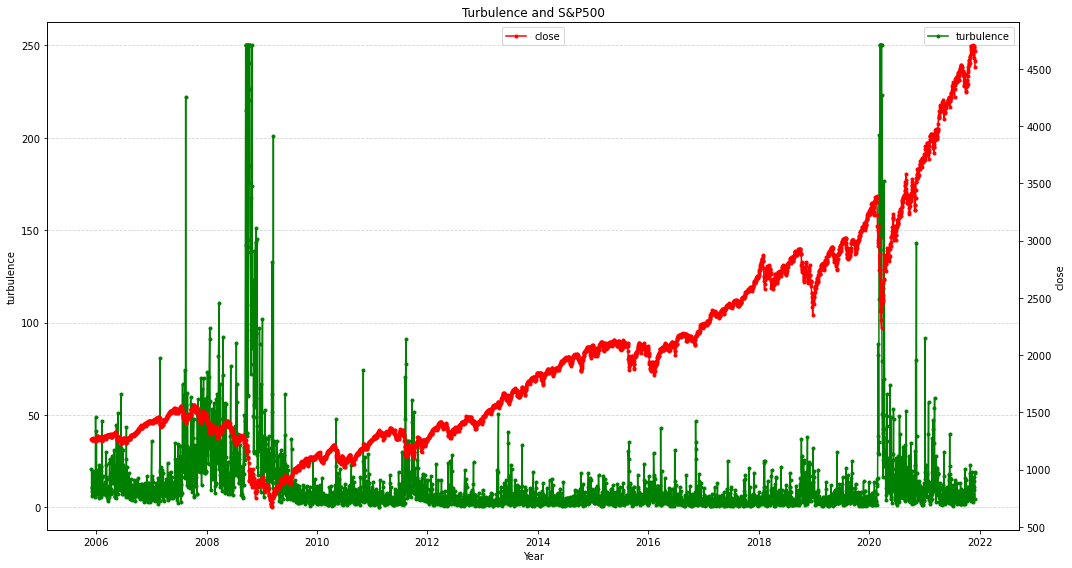

In [28]:
twin_plot(turb_sp)

In [29]:
#twin_plot(turb_sp[turb_sp.Date >= datetime.strptime("2010-01-01", "%Y-%m-%d").date()])

In [30]:
#import matplotlib.pyplot as plt
#turb.plot(figsize=(15,8))

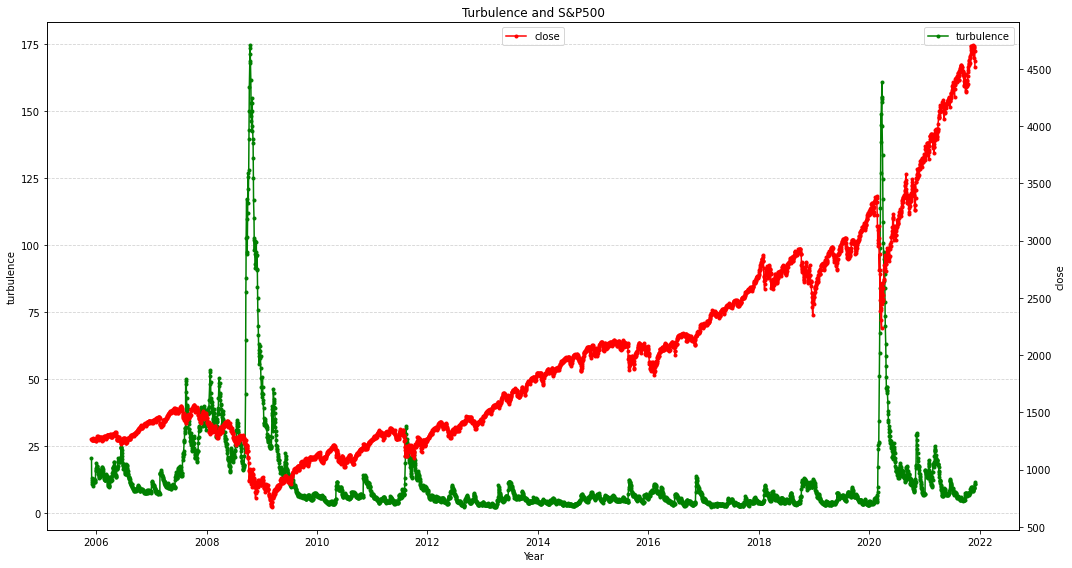

In [31]:
# Exponentially weighted moving average
turb_sp_ewm = turb_sp.copy()
#turb_sp_ewm['turbulence'] = turb_sp['turbulence'].ewm(span=15, adjust=False).mean()
turb_sp_ewm['turbulence'] = turb_sp['turbulence'].ewm(halflife='10 days', times=pd.DatetimeIndex(turb_sp_ewm.Date)).mean()

twin_plot(turb_sp_ewm)

### Equities only turbulence

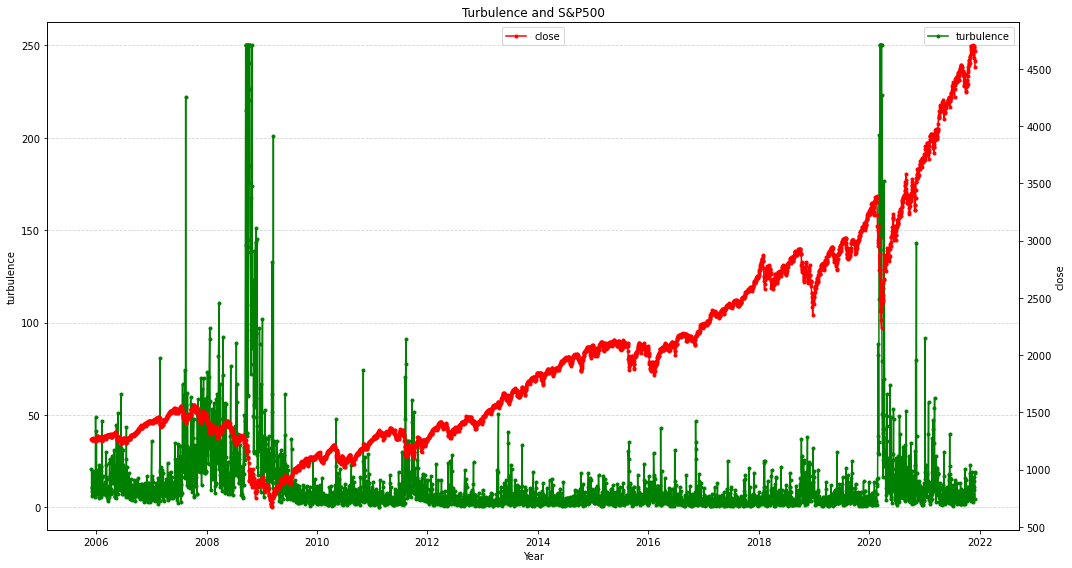

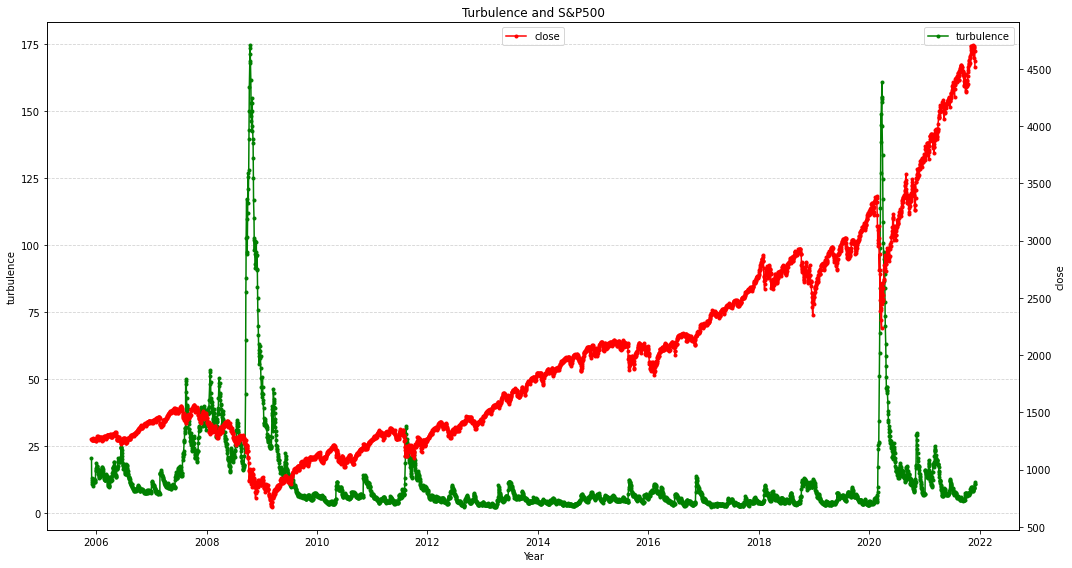

In [32]:
## Equities only turbulence
equities_columns = ["IJH", "IJR", "IVV", "IVE", "IVW","^GSPC","SPY"]
turb_equities = [{"Date": curr_date, 
         "turbulence": get_turbulence_for_date(wd_returns_pivot[equities_columns], curr_date, 365, 250)}
         for curr_date in wd_returns_pivot.index.values[252:] ]  
turb_equities  = pd.DataFrame(turb_equities)

turb_equities = turb.merge(work_data_df.loc[work_data_df.tic == "^GSPC", ["Date","close"]],
                     how = 'left',  
                     left_on = ["Date"], 
                     right_on = ["Date"])
turb_equities
import matplotlib.pyplot as plt
twin_plot(turb_equities)

# Exponentially weighted moving average
turb_equities_ewm = turb_equities.copy()
#turb_sp_ewm['turbulence'] = turb_sp['turbulence'].ewm(span=15, adjust=False).mean()
turb_equities_ewm['turbulence'] = turb_equities_ewm['turbulence']\
                                        .ewm(halflife='10 days', 
                                             times=pd.DatetimeIndex(turb_equities_ewm.Date))\
                                        .mean()

twin_plot(turb_equities_ewm)

#### Price Based Turbulence

In [33]:
wd_price_pivot = wd_te.pivot(index='Date', columns='tic', values='close')
wd_price_pivot = wd_price_pivot.dropna()
wd_price_pivot

tic,AGG,GLD,IEF,IJH,IJR,IVE,IVV,IVW,LQD,SHY,SPY,TLT,^GSPC
Date,,,,,,,,,,,,,
2004-12-01,59.327141,45.380001,54.277737,50.862514,21.891775,41.272484,85.602737,11.223229,55.630131,61.808098,85.401245,50.419254,1191.369995
2004-12-02,59.438156,44.950001,54.155266,50.807331,21.759459,41.099182,85.681442,11.309418,55.453678,61.785263,85.472878,50.215168,1190.329956
2004-12-03,59.782990,45.599998,54.696693,51.028065,21.762167,41.132500,85.588425,11.291787,55.766193,61.921860,85.415558,50.996677,1191.170044
2004-12-06,59.847263,45.169998,54.799828,50.677273,21.606892,41.219143,85.638496,11.262408,55.922497,61.929447,85.386909,51.171627,1190.250000
2004-12-07,59.929157,45.110001,54.793339,50.117611,21.203228,40.752571,84.765465,11.164473,56.053596,61.929447,84.591881,51.235798,1177.069946
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-24,113.549500,167.119995,113.813438,286.450012,117.459999,153.630005,471.279999,83.150002,131.373611,85.600082,469.440002,146.641800,4701.459961
2021-11-26,114.358353,166.850006,115.282326,277.359985,113.050003,149.960007,460.619995,81.449997,132.441681,85.769981,458.970001,150.347290,4594.620117
2021-11-29,114.418274,166.619995,115.022522,277.459991,112.779999,150.649994,466.500000,83.019997,132.531525,85.809959,464.600006,149.138763,4655.270020


In [34]:
turb_price = [{"Date": curr_date, 
               "turbulence": get_turbulence_for_date(wd_price_pivot,curr_date,365, clip=600)
              }
              for curr_date in wd_price_pivot.index.values[252:] ]  
turb_price  = pd.DataFrame(turb_price)

turb_prc_sp = turb_price.merge(work_data_df.loc[work_data_df.tic == "^GSPC", ["Date","close"]],
                    how ='left',  
                    left_on=["Date"], 
                 right_on=["Date"])
turb_prc_sp

,Date,turbulence,close
0,2005-11-30,18.950458,1249.479980
1,2005-12-01,27.050110,1264.670044
2,2005-12-02,26.110526,1265.079956
3,2005-12-05,21.159956,1262.089966
4,2005-12-06,24.900307,1263.699951
...,...,...,...
4024,2021-11-24,79.674667,4701.459961
4025,2021-11-26,80.682240,4594.620117
4026,2021-11-29,103.323526,4655.270020
4027,2021-11-30,108.916817,4567.000000


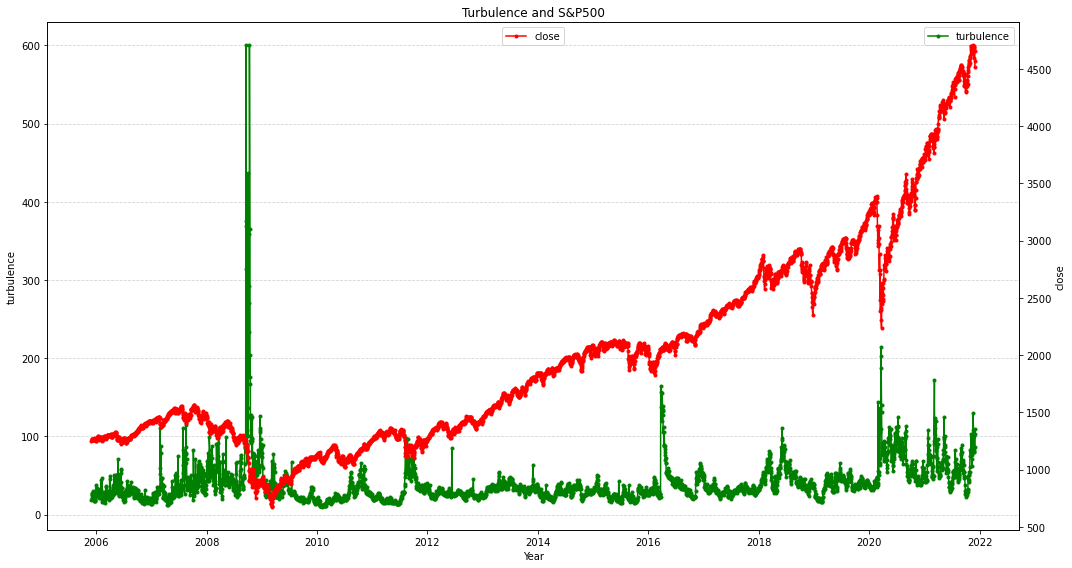

In [35]:
import matplotlib.pyplot as plt
twin_plot(turb_prc_sp)